# [ML-02] Imbalanced learning

## Class imbalance

In classification, the target is a categorical variable with a (typically small) collection of values, which we call **classes**. When the data collection is driven by the availability of data, it is not rare for the proportion of training units of one class to be significantly different from the proportion of units of the other classes. This is called **class imbalance**. Though it does not receive enough attention in learning materials, class imbalance is quite frequent in applications. Examples are **credit scoring** or **fraud detection**. It also occurs in **direct marketing**, since **conversion rates** are typically low.

To simplify, let us assume a binary classification context, with two classes, positive and negative. Typically, class imbalance happens because the positive training units are much less frequent than the negative ones. Imbalance can be extreme in some applications. For instance, for fraud detection in credit card transactions, the proportion of fraudulent transactions is typically below 1%. 

In such a extreme situation, many recommended metrics for model evaluation don't make sense. The accuracy, for instance. The **total accuracy** value that we see in the evaluation report of a classification model is the weighted average of the accuracy in the positive class and the accuracy in the negative class. If the positive class is much smaller than the negative class, the accuracy in the positive class has practically no influence in the total accuracy. So, a model can have a very good total accuracy but a poor accuracy in the positive class. Moreover, it may be that the learning process pushes the model selection in that direction.

Various approaches have been proposed to address the class imbalance problem. They constitute the so called **imbalanced learning**. This lecture is a short introduction to this methodology.


## The scoring approach

A classification model predicts a set of **class probabilities** for every data unit. In scikit-learn, this is given by the method `.predict_proba()`. In the default prediction, the predicted class is the one with the highest probability. In scikit-learn, this is what the method `.predict()` does. One way of dealing with class imbalance is to step back to the class probabilities, using them directly.

In binary classification, the two class probabilities are complementary, so we focus on the positive class probability, which we call **predictive score**. In terms of these scores, the default prediction consists in predicting as positive those units for which the score exceeds 0.5. One way of coping with imbalance is to lower this threshold to a value closer to the actual proportion of positive training units. This is simple and easy to manage under moderate class imbalance. 

Nevertheless, under extreme class imbalance, the predicted class may be too sensitive to small changes in the threshold. Because of this, and also because users find that the scores are more "managerial" that the binary prediction, using the scores in business is common practice, in particular in fields like credit scoring or fraud detection. Decisions may be based on the scores, without an explicit pre-specified threshold.

The scoring approach popped up in the preceding lecture, and it is illustrated again in the example of this lecture. Alternative approaches, based on resampling the training data, are explained below, though the practice is left for the homework.

## Resampling

In a **resampling** approach, we train the model on a modified data set, in which the class imbalance has been artificially corrected. A **random sampling** process is sometimes associated to these methods. There are various resampling methods, but we can summarize them as: 

* **Undersampling**: we reduce the number of negative training units to match the number of positive training units.

* **Oversampling**: we increase the number of positive training units to match the number of negative training units.

A specialized package, `imblearn`, complements scikit-learn with a resampling toolkit. But, instead of `imblearn`, we propose here the Pandas method `.sample()`, which makes everything obvious.

## Undersampling

Undersampling typically proceeds by randomly dropping as many negative units as needed to match the positive units. So, we end up with a perfectly balanced data set. Let us suppose that the training data are stored in a Pandas data frame `df`, in which the target column is a dummy named `class`, so we have `class=1` for the positive units and `class=0` for the negative units:

We split the training data in two subsets as:

```
df0, df1 = df[df['class'] == 0], df[df['class'] == 1]
```

The number of negative and positive units are:

```
n0, n1 = df0.shape[0], df1.shape[0]
```

Class imbalance means that `n0` is much bigger than `n1`. We extract from `df0` a random subset, with `n1` rows:

```
df0_under = df0.sample(n1)
```

Then, we join this reduced data set to the positive training subset.

```
df_under = pd.concat([df0_under, df1])
```

Now, `df_under` is balanced, with `n1` positive units and `n1` negative units.

## Oversampling

Oversampling adds extra positive units, so we end up with a pefectly balanced data set. These additional positive units can be obtained either by replicating existing positive units or by generating artificial, nonexisting units by interpolation. The top popular method for interpolation is **SMOTE** (Synthetic Minority Oversampling TEchnique).

We only consider the first approach here. The Python code would be similar to that used for undersampling. Once the training data set has been split, we apply the method `.sample()` to `df1` with the argument `replace=True` (the default is `replace=True`). This extracts from `df1`a random sample of rows, with some units eventually repeated.

 ```
df1_over = df1.sample(n0 - n1, replace=True)
```

We add then the extra units to the original data set.

```
df_over = pd.concat([df, df1_over])
```

Now, `df_over` is balanced, with `n0` positive units and `n0` negative units.

## Example - Direct marketing of term deposits

### Introduction

There are two main approaches for companies to promote products and/or services: through **mass campaigns**, targeting a general indiscriminate public, or through **direct marketing**, targeting a specific set of contacts. Nowadays, in a global competitive world, positive responses to mass campaigns are typically very low. Alternatively, direct marketing focuses on targets that assumably will be keener to that specific product/service, making these campaigns more efficient. But the increasingly vast number of marketing campaigns has reduced their effect on the general public. Furthermore, economical pressures and competition has led marketing managers to invest on direct campaigns with a strict and rigorous selection of contacts.

Ten years ago, due to the internal competition and the current financial crisis, there were huge pressures for European banks to increase their financial assets. One strategy is to offer attractive **long-term deposit** applications with good interest rates, in particular through direct marketing. A Portuguese institution had been offering term deposits to its clients for the last two years, but in a way that the board finds disorganized and inefficient. Too many contacts were made for the subscriptions obtained.

The bank had been using its own contact-center to carry out direct marketing campaigns. The telephone was the dominant marketing channel, sometimes with the help of the Internet online banking channel (*e.g*. by showing information to a specific targeted client). Furthermore, each campaign was managed in an integrated fashion and the results for all channels were outputted together.

The manager in charge of the next campaign was expected to optimize the effort. His objective was to derive, from the data of the preceding campaign  a **predictive model** for the success of a contact, *i.e*. whether the client subscribes the deposit. That model would increase the campaign's efficiency by identifying the main characteristics that affected success, helping in a better management of the available resources (*e.g*. human effort, phone calls and time) and the selection of a high quality and affordable set of potential clients. To be useful for the direct campaign, a predictive model must allow reducing the number of calls in a relevant way, without losing a relevant number of subscribers.

### The data set

The data for this example come from the previous phone campaign of the bank, which involved a total of 45,211 contacts. During that campaign, an attractive long-term deposit application, with good interest rates, was offered. The contacts led to 5,289 subscriptions, a 11.7% **conversion rate**.

The data set combines demographic data with data about the interaction of the client and the bank. Some of the categorical variables (the type of job, the marital status, etc) have been transformed into **dummy variables** (1/0) so they can enter an equation:

* The client's account number (`accnum`).

* The client's  age in years (`age`).

* The client's type of job (`job`). The values are 'admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'student', 'technician', 'unknown' and 'unemployed'. Converted to twelve dummies.

* The client's marital status (`marital`). The values are 'married', 'divorced' and 'single'. Converted to three dummies.

* The client's education level (`education`). The values are 'unknown', 'secondary', 'primary' and 'tertiary'. Converted to four dummies.

* Whether the client had credit in default (`default`). The values are 'yes' and 'no'. Converted to a dummy (1 = yes, 0 = no).

* The client's average yearly balance in euros (`balance`).

* Whether the client had a housing loan (`housing`). The values are 'yes' and 'no'. Converted to a dummy (1 = yes, 0 = no).

* Whether the client had a personal loan (`loan`). The values are 'yes' and 'no'. Converted to a dummy (1 = yes, 0 = no).

* The usual communication channel with the client (`contact`). The values are 'unknown', 'telephone' and 'cellular'. Converted to three dummies.

* The duration of the last contact with the client before the campaign in seconds (`duration`). 

* The number of days passed by after the client was last contacted from a previous campaign (`pdays`). The entry is -1 when the client had not been previously contacted.

* The number of contacts performed before this campaign and for this client (`previous`).

* The outcome of the previous marketing campaign with the client (`poutcome`). The values are 'unknown', 'other', 'failure' and 'success'. Converted to four dummies.

* Whether the client had subscribed a term deposit (`deposit`). The values are 'yes' and 'no'. Converted to a dummy (1 = yes, 0 = no). This is the target of the predictive model to be developed.

Source: S Moro, P Cortez & P Rita (2014), A data-driven approach to predict the success of bank telemarketing, *Decision Support Systems* **62**, 22-31.

### Questions

Q1. Develop a **logistic regression model** to predict the response to the campaign (`deposit`) from the other variables.

Q2. Use your model to assign, to every client, a **predictive score** for subscribing the deposit. How is the distribution of the scores? Is it different for the subscribers and the non-subscribers?

Q3. Set a **threshold** for the scores to adequate the model to your business purpose.

Q4. Based on your model, if a **target** of 4,000 subscriptions has been set, how many calls would be needed to hit the target?

Q5. Setting a **budget** of 10,000 calls, how would you select the clients to be called? How many subscriptions would be achieved?

### Importing the data

As in the preceding lecture, we use the Pandas funcion `read_csv()` to import the data from a GitHub repository. We take the column `accnum` as the index (`index_col=0`).

In [1]:
import pandas as pd
path = 'https://raw.githubusercontent.com/lab30041954/Data/main/'
df = pd.read_csv(path + 'deposit.csv', index_col=0)

### Exploring the data

We print a report of the content of `df` with the method `.info()`. Everything comes as expected, so far. There are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45211 entries, 2065031284 to 2086934257
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   job_admin            45211 non-null  int64
 2   job_blue-collar      45211 non-null  int64
 3   job_entrepreneur     45211 non-null  int64
 4   job_housemaid        45211 non-null  int64
 5   job_management       45211 non-null  int64
 6   job_retired          45211 non-null  int64
 7   job_self-employed    45211 non-null  int64
 8   job_services         45211 non-null  int64
 9   job_student          45211 non-null  int64
 10  job_technician       45211 non-null  int64
 11  job_unemployed       45211 non-null  int64
 12  job_unknown          45211 non-null  int64
 13  marital_divorced     45211 non-null  int64
 14  marital_married      45211 non-null  int64
 15  marital_single       45211 non-null  int64
 16  education_pri

We also display the first five rows:

In [3]:
df.head()

,age,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,channel_telephone,channel_unknown,duration,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit
accnum,,,,,,,,,,,,,,,,,,,,,
2065031284,58,0,0,0,0,1,0,0,0,0,...,0,1,261,-1,0,0,0,0,1,0
2051283096,44,0,0,0,0,0,0,0,0,0,...,0,1,151,-1,0,0,0,0,1,0
2029034586,33,0,0,1,0,0,0,0,0,0,...,0,1,76,-1,0,0,0,0,1,0
2070859436,47,0,1,0,0,0,0,0,0,0,...,0,1,92,-1,0,0,0,0,1,0
2098635102,33,0,0,0,0,0,0,0,0,0,...,0,1,198,-1,0,0,0,0,1,0


Finally, we check the conversion rate:

In [4]:
df['deposit'].mean().round(3)

0.117

*Note*. The value -1 in the column `pdays`, when a client has not been previously contacted, may look strange, but it is irrelevant in this case, since this situation is covered by the dummy `poutcome_unknown`. It can be proved, with a bit of algebra, that replacing the imputed value -1 by a different choice would lead to a model with exactly the same predicted values.

### Q1. Logistic regression model


We create a target vector and a features matrix. The target vector is the last column (`deposit`) and the features matrix integrates the other columns.

In [5]:
y = df['deposit']
X = df.drop(columns='deposit')

To develop our logistic regression model with scikit-learn, we instantiate an estimator from the class `LogisticRegression()`, from the subpackage `linear_model`, applying the method `.fit()` as in the preceding lecture. We also increase here the maximum number of iterations.

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=4000)
clf.fit(X, y)

LogisticRegression(max_iter=4000)

The default predictions and the corresponding confusion matrix are obtained as in the preceding lecture.

In [7]:
y_pred = clf.predict(X)
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[38989,   933],
       [ 3602,  1687]])

On one side, these results look fine, since, with this model, we will call only 2,673 clients, capturing 1,719 subscriptions (64.3% conversion rate). On the other side, we are missing 3,570 potential subscribers (70.9%). The total accuracy can be extracted from the confusion matrix, or calculated directly:

In [8]:
acc = (y == y_pred).mean().round(3)

The accuracies on the two groups are:

In [9]:
acc1 = y_pred[y == 1].mean().round(3)
acc0 = (1 - y_pred[y == 0]).mean().round(3)

We can print them together as:

In [10]:
acc, acc1, acc0

(0.9, 0.319, 0.977)

So, we have a very high accuracy on the negative group, but a poor accuracy on the positive group. This is typical of imbalanced training data. Let us see how this may change if we use the predictive scores.

### Q2. Predictive scores

The predictive scores come as the second column of the 2D array returned by the method `.predict_proba()`. We add them to the current data set.

In [11]:
df['score'] = clf.predict_proba(X)[:, 1]
df[['deposit', 'score']].head()

,deposit,score
accnum,,
2065031284,0,0.021595
2051283096,0,0.013961
2029034586,0,0.003413
2070859436,0,0.008147
2098635102,0,0.039772


On average, the scores are correct, and have a skewed distribution (nothing wrong with this), as shown in the statistical summary.

In [12]:
df['score'].describe()

count    45211.000000
mean         0.116995
std          0.177737
min          0.002186
25%          0.023696
50%          0.052332
75%          0.114036
max          1.000000
Name: score, dtype: float64

As in the preceding lecture, we get a better view with separate histograms. The code is the same.

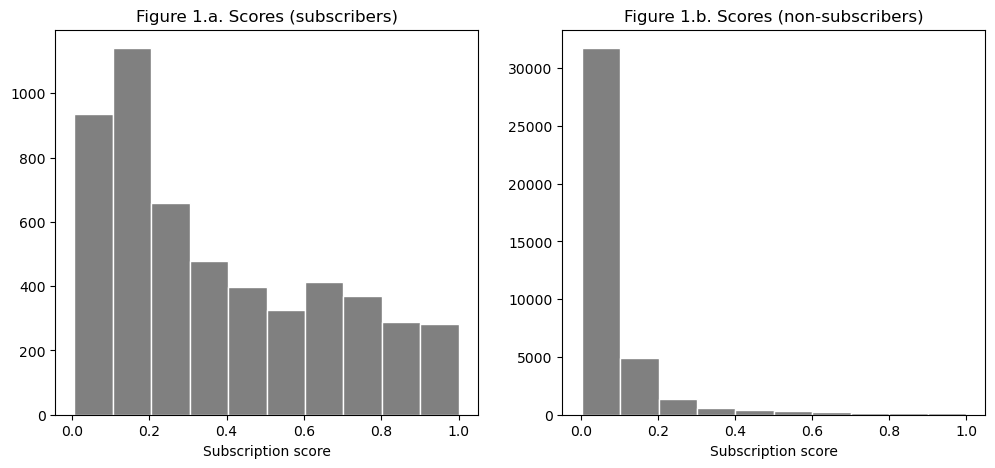

In [13]:
from matplotlib import pyplot as plt
# Set the size of the figure
plt.figure(figsize=(12,5))
# First subplot
plt.subplot(1, 2, 1)
plt.hist(df['score'][y == 1], color='gray', edgecolor='white')
plt.title('Figure 1.a. Scores (subscribers)')
plt.xlabel('Subscription score')
# Second subplot
plt.subplot(1, 2, 2)
plt.hist(df['score'][y == 0], color='gray', edgecolor='white')
plt.title('Figure 1.b. Scores (non-subscribers)')
plt.xlabel('Subscription score');

These figures show what is wrong with the threshold 0.5. In order to capture at least 2/3 of the potential subscribers, we have to set the threshold within the range 10-20%.

### Q3. Set a threshold for the scores

Let us take the actual conversion rate (rounded) as the threshold.

In [14]:
y_pred = (df['score'] > 0.11).astype(int)

The  new confusion matrix is:

In [15]:
confusion_matrix(y, y_pred)

array([[32515,  7407],
       [  992,  4297]])

Based on this threshold, we would call 11,493 clients, getting 4,267 subscriptions (a 37.1% conversion rate), which represents 4/5 of the potential subscriptions. The accuracies are now similar for the two groups:

In [16]:
acc = (y == y_pred).mean().round(3)
acc1 = y_pred[y == 1].mean().round(3)
acc0 = (1 - y_pred[y == 0]).mean().round(3)
acc, acc1, acc0

(0.814, 0.812, 0.814)

### Q4. Target of 4,000 subscriptions

Let us suppose that the manager has set a target of of 4,000 subscriptions and uses the scores to select the clients to be contacted. This can be managed easily in a spreadsheet, though we continue here with Python.

We sort the data by the scores, in descending order:

In [17]:
df = df.sort_values('score', ascending=False)
df[['deposit', 'score']]

,deposit,score
accnum,,
2084617209,0,1.000000
2096318570,1,0.999988
2054970681,0,0.999986
2064903718,0,0.999965
2078910432,0,0.999960
...,...,...
2014356089,0,0.002558
2038624917,0,0.002504
2009467351,0,0.002488


The bank would start contacting the top scored clients, until getting the desired 4,000 subscriptions. This could be controlled by adding a column with the cumulative number of subscriptions, which can be created with the method `.cumsum()`.

In [18]:
df['cum_subscription'] = df['deposit'].cumsum()
df[['deposit', 'score', 'cum_subscription']]

,deposit,score,cum_subscription
accnum,,,
2084617209,0,1.000000,0
2096318570,1,0.999988,1
2054970681,0,0.999986,1
2064903718,0,0.999965,1
2078910432,0,0.999960,1
...,...,...,...
2014356089,0,0.002558,5289
2038624917,0,0.002504,5289
2009467351,0,0.002488,5289


The first row in which the column `cum_subscription` attains the target value 40,000 corresponds to the last client contacted. In total, 
this gives 9,788 clients.

In [19]:
(df['cum_subscription'] < 4000).sum() + 1

9857

# Q5. Budget of 10,000 calls

Suppose now that, instead of setting an objective, the budget for the campaign allows for a pre-specified number of contacts, for instance 10,000. We would pick then the first 10,000 rows of the data set. The account numbers of the selected clients would be provided by the index labels:

In [20]:
call_list = df.index[:10000]
call_list

Index([2084617209, 2096318570, 2054970681, 2064903718, 2078910432, 2041730862,
       2071098526, 2037940512, 2032450716, 2008541793,
       ...
       2023547980, 2072695310, 2079163540, 2026589413, 2026849375, 2025910843,
       2024935187, 2045907168, 2028350197, 2002618495],
      dtype='int64', name='accnum', length=10000)

The last of these account numbers would be the label `call_list[9999]` (2051370426). The number of subscriptions achieved would be:

In [21]:
df['cum_subscription'][call_list[9999]]

4019

### Homework

1. **Undersample** the data, by randomly dropping as many negative units as needed to match the positive units, so that you end up with a pefectly balanced (but smaller) training data set. Train a logistic regression model on this undersampled training data set and evaluate it, based on a confusion matrix. 

2. **Oversample** the data, by randomly adding as many duplicates of the positive units as needed to match the negative units, so that you end up with a pefectly balanced (but larger) training data set. Train a logistic regression model on this oversampled training data set and evaluate it, based on a confusion matrix.